# ERC-4337 Simulations
Importing all necessary library for running the simulations

In [2]:
import numpy as np
import pandas as pd
from cadCAD.configuration import Configuration
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from collections import deque
import matplotlib.pyplot as plt
import random

Here, I define an initial state for the simulation. We have a mempool, which initially is empty; a base fee (which, in the current implementation, is not being used; the plan is to use it later by dividing it among all the transactions inside a bundle to determine the total cost). Additionally, there's a bundle size, which could be changed in future simulations, perhaps by creating different types of transactions.

Then, we have three different dictionaries: the bundlers, which contains the inclusion fee that they request, the bundler transactions, which keeps track of how many transactions are accepted by each bundler; and the bundler earnings, which keeps track of how much a bundler earns in each timestamp.

We could also add some variables to keep track of the cost, but in this implementation, I am not keeping track of that.

In [3]:
# Define initial state variables
initial_state = {
    'mempool': [],  # Initially empty mempool
    'base_fee': 21000,  # Base fee
    "bundle_size": 25,
    'bundlers': {  # Bundlers with different asks for inclusion fee
        'BundlerA': 0.5,
        'BundlerB': 1.0,
        'BundlerC': 1.5,
        'BundlerD': 2.0,
    },
    'bundler_transactions': {bundler: 0 for bundler in ['BundlerA', 'BundlerB', 'BundlerC', 'BundlerD']},  # Initialize bundler transactions
    'bundler_earnings': {bundler: 0 for bundler in ['BundlerA', 'BundlerB', 'BundlerC', 'BundlerD']},  # Initialize bundler earnings
}

Here, I have a function that randomly generates some transactions. Each transaction has an inclusion fee selected randomly between two parameters, in this case, 0.3 to 2.5. Once these transactions are created, if they are not already present in the mempool, they get added. By changing the variables in the random functions, we could observe different interesting behaviors in the simulations.

In [4]:
def generate_transactions(params, step, sL, s):
    new_transactions = []  # Initialize an empty list to store new transactions
    num_transactions = np.random.randint(50, 60)  # Generate random number of transactions
    
    for _ in range(num_transactions):
        base_fee = initial_state['base_fee']  # Base fee
        inclusion_fee = np.random.uniform(0.3, 2.5)  # Random inclusion fee
        new_transaction = {'base_fee': base_fee, 'inclusion_fee': inclusion_fee}
        
        # Check if the transaction is not already in the mempool
        if new_transaction not in s['mempool']:
            new_transactions.append(new_transaction)  # Add the new transaction to the list
            s['mempool'].append(new_transaction)  # Add the new transaction to the mempool

    return {'new_transactions': new_transactions}


Include_transactions__in_bundlers, the main function in the model. I add some randomness by shuffling the bundlers dictionary at each transaction. What happens in the allocation is as follows: if the inclusion fee is below 0.5, it doesn't get added to any bundlers since the cheapest one asks for an inclusion fee of 0.5. If the transaction has an inclusion fee between 0.5 to 1, it gets added to bundler A; if it's equal to or more than 1 but less than 1.5, it gets added to bundler A or B; if it's more than 1.5 but less than 2, it gets added randomly to A, B, or C; and if it's more than 2, it's added randomly to one of the bundlers.

The bundler size is also taken into account; if a bundler doesn't have space in its bundle, it can't accept new transactions. Once the transaction is added to a bundler, it gets deleted from the mempool. We keep track of the mempool by deleting only allocated transactions. By doing so, we can plot the misses because of a low inclusion fee or because the bundler is full at that moment.

In [5]:
def include_transactions_in_bundlers(params, step, sL, s, _input):
    new_trans = _input["new_transactions"]
    
    # Reset bundler transactions at the beginning of each timestep
    if step == 1:
        s['bundler_transactions'] = {bundler: 0 for bundler in s['bundlers']}
        #print(len(s["mempool"]))
    
    # Allocate transactions to bundlers and remove them from mempool
    for transaction in new_trans:
        inclusion_fee = transaction['inclusion_fee']
        #print("Transaction Inclusion Fee:", inclusion_fee)
        allocated = False
        
        # Shuffle bundlers to introduce randomness
        shuffled_bundlers = list(s['bundlers'].keys())
        random.shuffle(shuffled_bundlers)
        
        for bundler in shuffled_bundlers:
            if s['bundler_transactions'][bundler] < s['bundle_size']:
                if 0.5 <= inclusion_fee < 1:
                    if bundler == 'BundlerA':
                        #print("Allocating transaction to", bundler)
                        s['bundler_transactions'][bundler] += 1
                        s['bundler_earnings'][bundler] += inclusion_fee
                        allocated = True
                        s['mempool'].remove(transaction)  # Remove the transaction from mempool
                        break
                
                elif 1 <= inclusion_fee < 1.5:
                    if bundler in ['BundlerA', 'BundlerB']:
                        #print("Allocating transaction to", bundler)
                        s['bundler_transactions'][bundler] += 1
                        s['bundler_earnings'][bundler] += inclusion_fee
                        allocated = True
                        s['mempool'].remove(transaction)  # Remove the transaction from mempool
                        break
                
                elif 1.5 <= inclusion_fee < 2.0:
                    if bundler in ['BundlerA', 'BundlerB', 'BundlerC']:
                        #print("Allocating transaction to", bundler)
                        s['bundler_transactions'][bundler] += 1
                        s['bundler_earnings'][bundler] += inclusion_fee
                        allocated = True
                        s['mempool'].remove(transaction)  # Remove the transaction from mempool
                        break
                
                elif inclusion_fee >= 2:
                    #print("Allocating transaction to", bundler)
                    s['bundler_transactions'][bundler] += 1
                    s['bundler_earnings'][bundler] += inclusion_fee
                    allocated = True
                    s['mempool'].remove(transaction)  # Remove the transaction from mempool
                    break
        #if not allocated:
        #    print("Transaction not allocated to any bundler")
    
    return ('bundler_transactions', 'bundler_earnings'), (s['bundler_transactions'], s['bundler_earnings'])

Setting up CADCAD simulations, I skip the timestep 0 since the mempool is empty and nothing happens at t=0

In [6]:
simulation_params = { 
    'T': range(100),  # Time steps
    'N': 1,  # Number of Monte Carlo runs
    'M': {},  # Parameters
}

psub = [
    {
        'policies': {
            "new_transactions": generate_transactions
        },
        'variables': {
            "bundler_transactions": include_transactions_in_bundlers 
            
        },
    }
]
# Simulate the updated model
# Define your simulation configuration
config = Configuration(
    initial_state=initial_state, 
    partial_state_update_blocks=psub,
    sim_config=simulation_params,
    user_id=0,
    model_id=0,
    simulation_id=0,
    subset_id=0,
    subset_window=deque([0, 0]),
    state_history=True
)

# Define execution context
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)

# Create executor
executor = Executor(exec_context, [config])

# Execute simulation
raw_result, tensor, session = executor.execute()

df = pd.DataFrame(raw_result)
#Skipping timesteps 0 
time_steps = df.index[1:]
bundler_transactions = df['bundler_transactions']
bundler_earnings = df['bundler_earnings']



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 0, 1, 6)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 0, 1, 6)
Execution Method: single_proc_exec
Execution Mode: single_threaded
Total execution time: 0.54s


Here we show the transactions per bundler overtime we can see at which timestemps a bundlers gets a full bundle size and the how having a lower inclusion fee obviously makes the bundler get more transactions. 

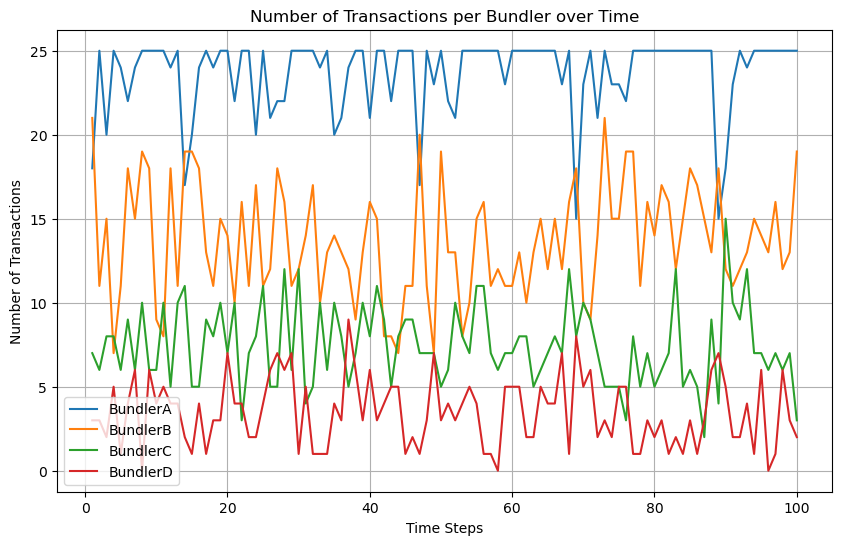

In [7]:
# Plot the data
plt.figure(figsize=(10, 6))
for bundler in bundler_transactions.iloc[0].keys():
    transactions = [data[bundler] for data in bundler_transactions[1:]]
    plt.plot(time_steps, transactions, label=bundler)

plt.title('Number of Transactions per Bundler over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.show()

Here we plot the earnings for each bundlers

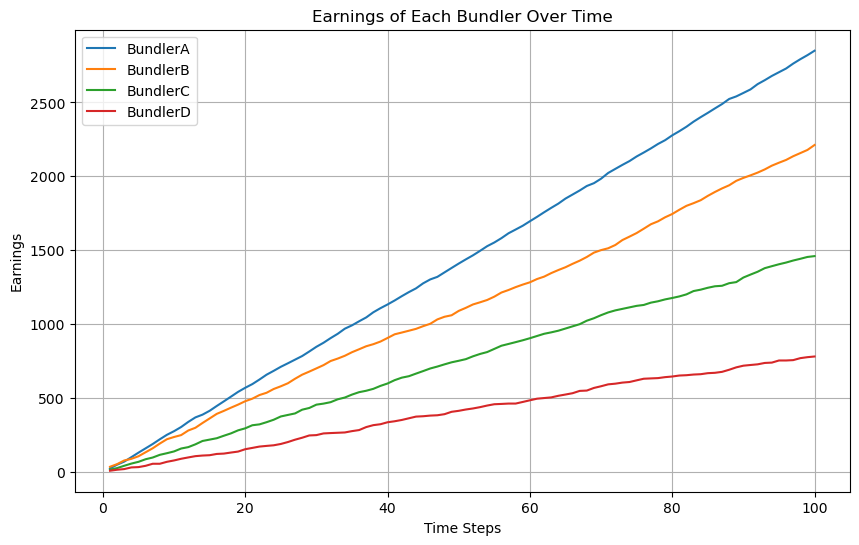

In [8]:
# Plot the earnings of each bundler over time
plt.figure(figsize=(10, 6))
for bundler in bundler_earnings.iloc[0].keys():
    earnings = [data[bundler] for data in bundler_earnings[1:]]
    plt.plot(time_steps, earnings, label=bundler)

plt.title('Earnings of Each Bundler Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Earnings')
plt.legend()
plt.grid(True)
plt.show()

Here we plot the transactions that could get allocated in the bundle and the one that couldn't get included

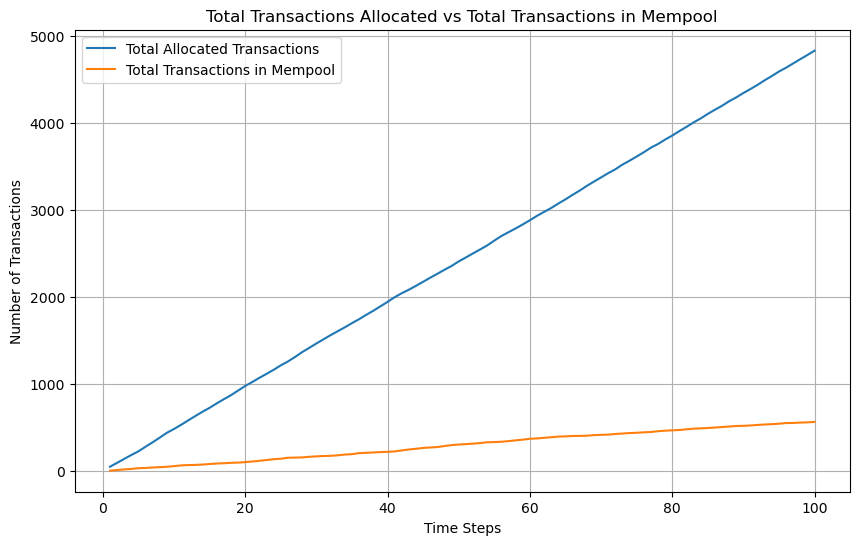

In [11]:
# Extract total transactions allocated to bundlers and total transactions remaining in the mempool
total_allocated_transactions = []
total_mempool_transactions = []

allocated_cumulative_total = 0
for idx, row in df.iterrows():
    allocated_cumulative_total += sum(row['bundler_transactions'].values())
    total_allocated_transactions.append(allocated_cumulative_total)
    total_mempool_transactions.append(len(row['mempool']))

total_allocated_transactions = total_allocated_transactions[1:]
total_mempool_transactions = total_mempool_transactions[1:]
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_steps, total_allocated_transactions, label='Total Allocated Transactions')
plt.plot(time_steps, total_mempool_transactions, label='Total Transactions in Mempool')

plt.title('Total Transactions Allocated vs Total Transactions in Mempool')
plt.xlabel('Time Steps')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.show()


We can see from the simulations the number of transactions added per bundler and their respective total returns. Interesting insights can be seen by varying the bundle size, the number of transactions added to the mempool, and the different inclusion fees.

In the following plots, I modify the bundle size and the number of transactions. In the last plot, I also demonstrate the effects of changing the inclusion fee.

This is the result of a simulation with a bundle size of 10, where the generated transactions range between 20 and 30

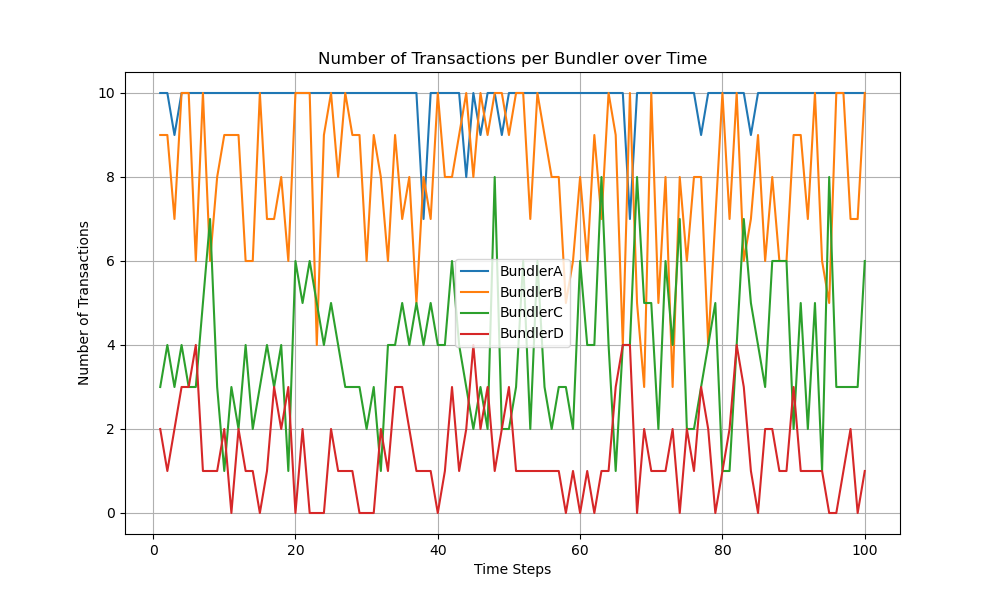

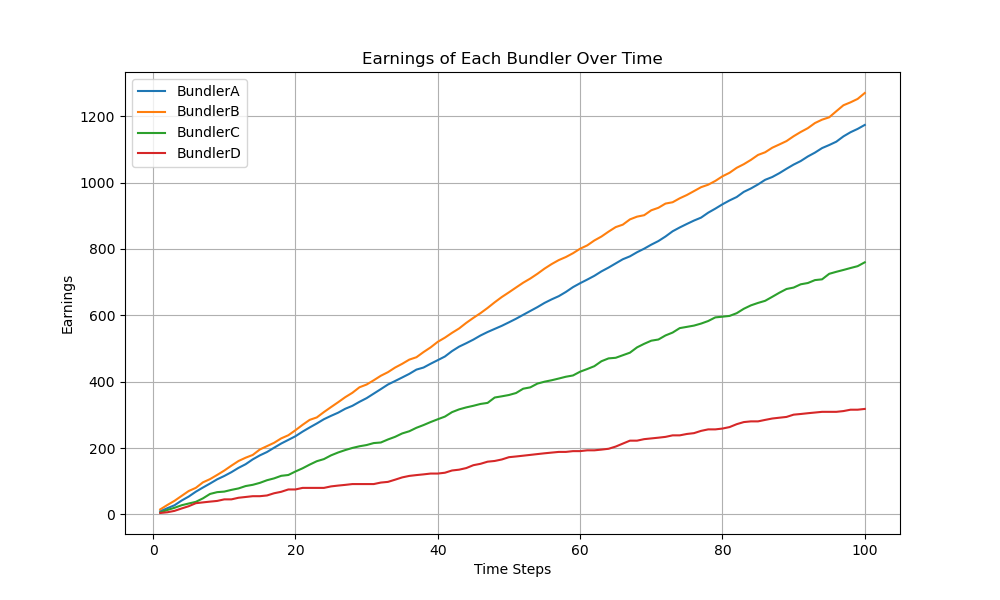

Simulations with bundle size of 25 and 50 to 100 transactions generated at each timestep.

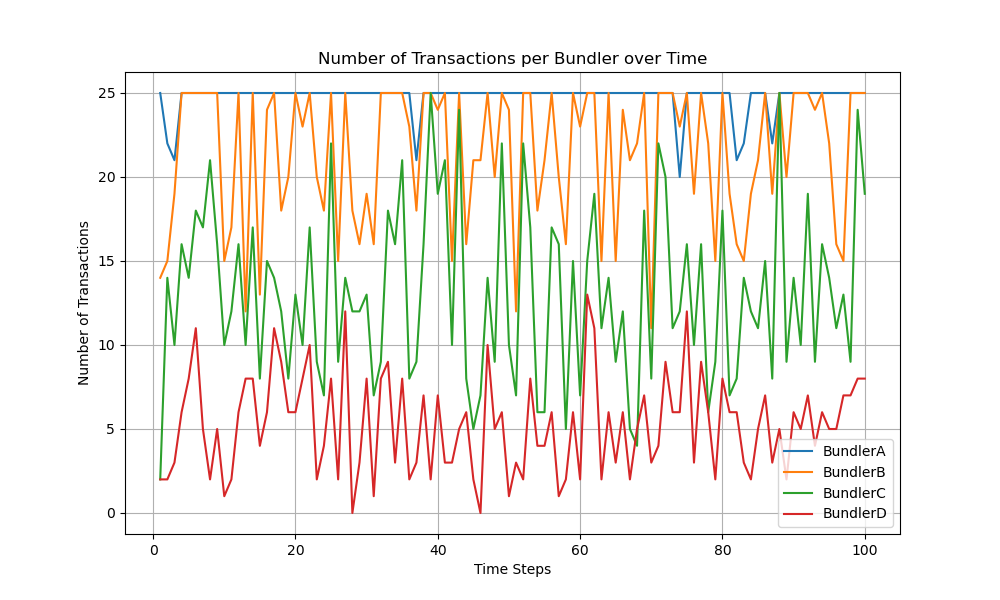

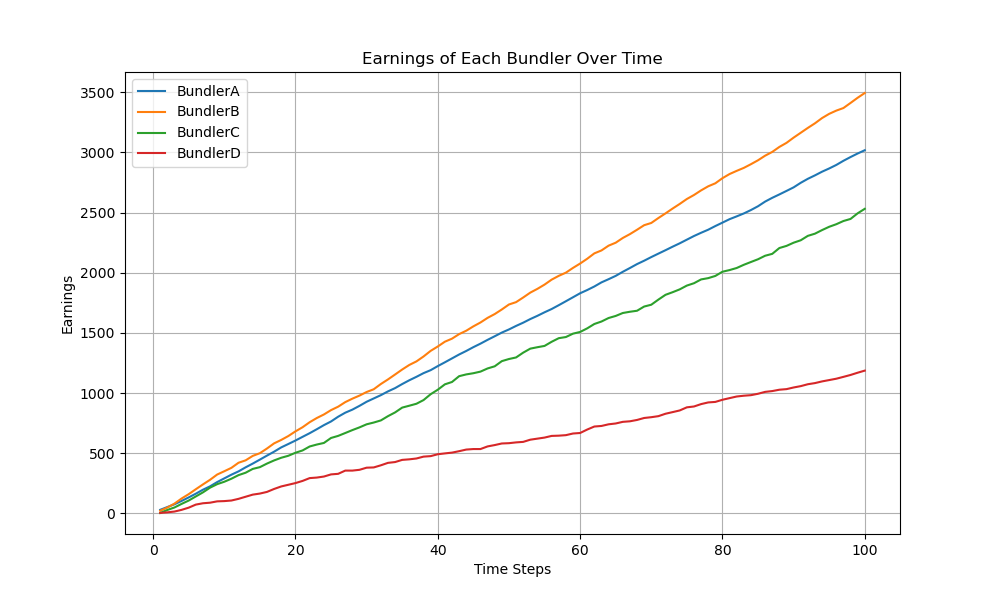

Changing the bundle size to 30 keeping the transactions the same between 50 to 100

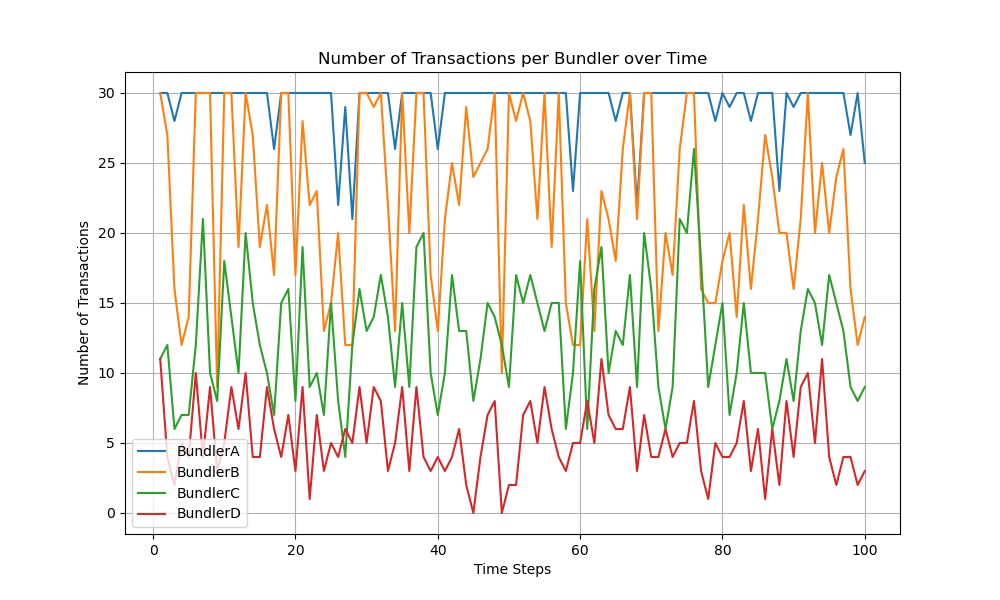

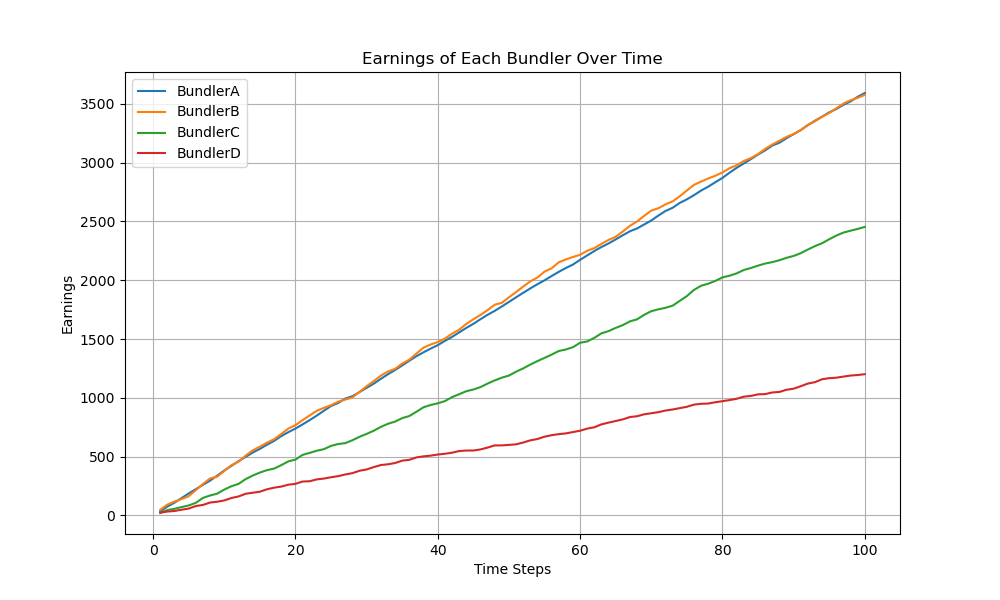

For the next plot, we maintain the bundle size at 30 and the number of transactions at 50 and 100, but we change the inclusion fee to be generated between 0.2 and 2.5

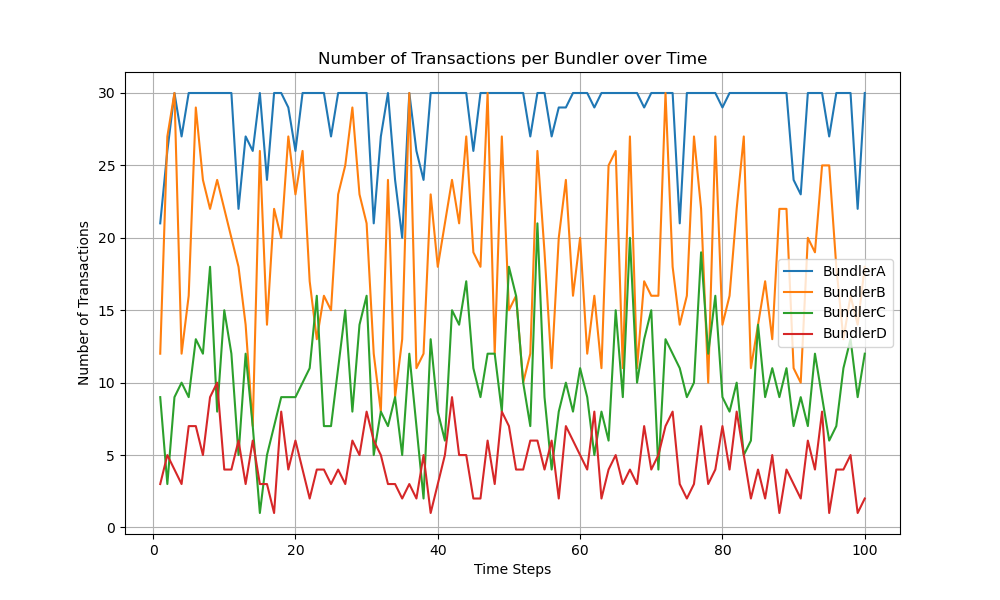

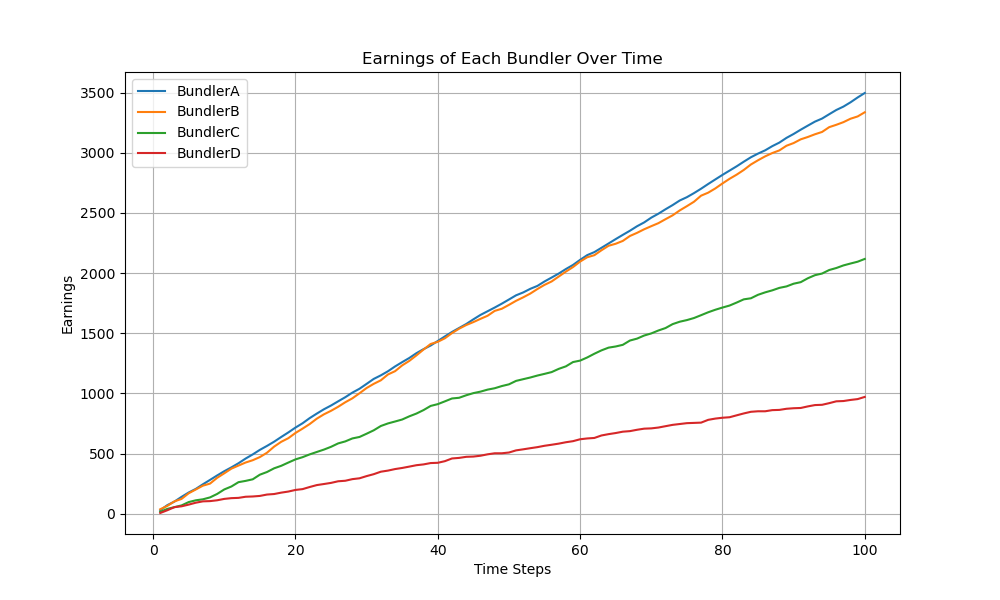

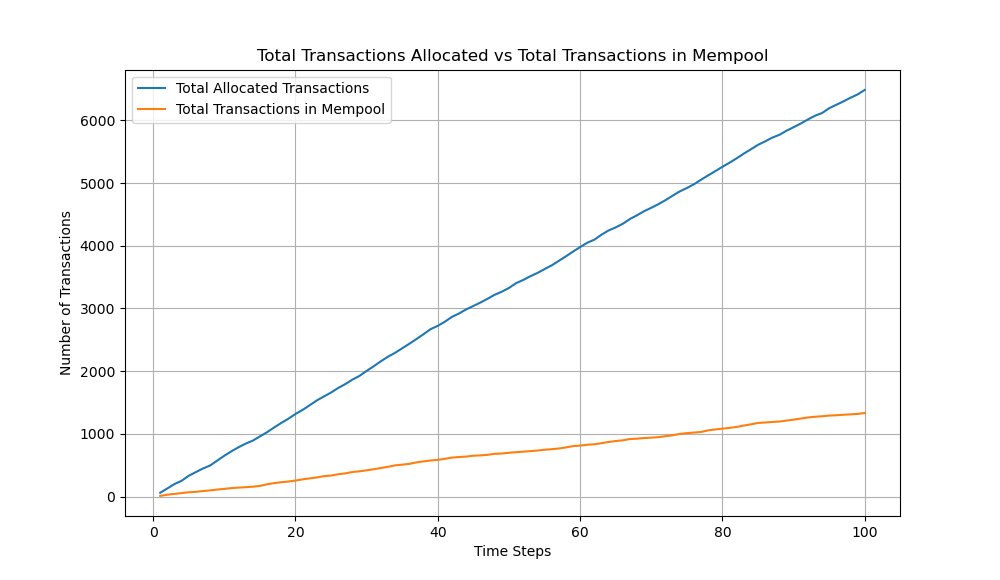